In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.loader import DataLoader

from datasets.random_graphs import ERGraphDataset
from models.mpnn import MPNN
from models.iwn import IWN2
from models.simple_higher_order_wnn import SimpleGNN3

In [24]:
node_sizes = list(range(10, 201, 10))

er_dataset = ERGraphDataset(
    node_sizes=node_sizes,
    edge_prob=0.5,
    edge_weight=1.0,
    fully_connected=False,
    graphs_per_size=200,
)
fc_dataset = ERGraphDataset(
    node_sizes=node_sizes,
    edge_prob=1.0,
    edge_weight=0.5,
    fully_connected=True,
    graphs_per_size=1,
)

In [25]:
models = {
    'MPNN': MPNN,
    '2-OWL IWN': IWN2,
    'Simple 2-FWL GNN': SimpleGNN3,
}

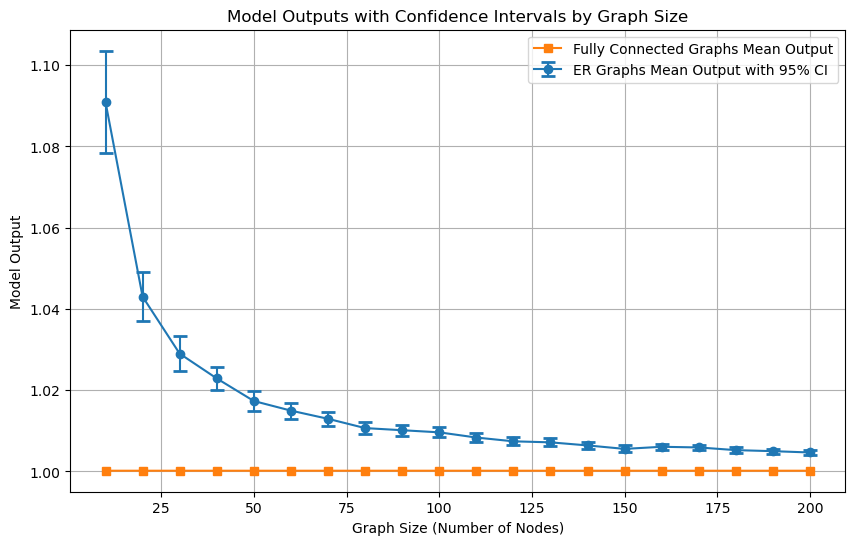

In [47]:
model = SimpleGNN3(in_channels=1, hidden_channels=1, num_layers=2)

def get_outputs_by_size(dataset):
    size_outputs = {size: [] for size in node_sizes}
    with torch.no_grad():
        dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
        for batch in dataloader:
            size = int(batch.x.size(0))
            out = model(batch.x, batch.edge_index, batch.edge_weight, batch.batch)
            size_outputs[size].append(out.item())
    return size_outputs

er_outputs = get_outputs_by_size(er_dataset)
fc_outputs = get_outputs_by_size(fc_dataset)

# Calculating confidence intervals for ER graphs
er_means, er_conf_intervals = [], []
for size in node_sizes:
    outputs = np.array(er_outputs[size])
    mean = np.mean(outputs)
    std_error = np.std(outputs, ddof=1) / np.sqrt(len(outputs))
    conf_interval = 1.96 * std_error  # 95% confidence interval
    er_means.append(mean)
    er_conf_intervals.append(conf_interval)

# Calculating mean outputs for FC graphs (single value, no CI needed)
fc_means = [np.mean(fc_outputs[size]) for size in node_sizes]

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(node_sizes, er_means, yerr=er_conf_intervals, fmt='o-', capsize=5, capthick=2, label="ER Graphs Mean Output with 95% CI")
plt.plot(node_sizes, fc_means, 's-', label="Fully Connected Graphs Mean Output")
plt.xlabel("Graph Size (Number of Nodes)")
plt.ylabel("Model Output")
plt.title("Model Outputs with Confidence Intervals by Graph Size")
plt.legend()
plt.grid(True)
plt.show()

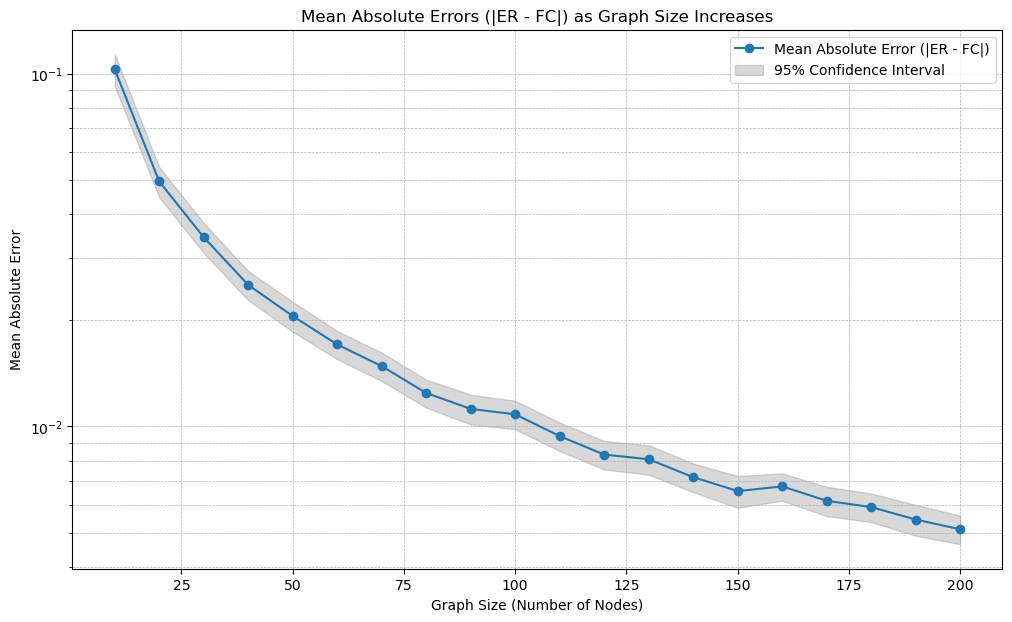

In [48]:
# Assuming `node_sizes`, `er_outputs`, and `fc_outputs` are defined

# Initialize lists to store results
mean_absolute_errors = []
conf_intervals = []

# Calculate mean absolute errors and confidence intervals
for size in node_sizes:
    er_vals = np.array(er_outputs[size])
    fc_mean = np.mean(fc_outputs[size])
    absolute_errors = np.abs(er_vals - fc_mean)
    
    # Calculate mean absolute error
    mean_abs_error = np.mean(absolute_errors)
    mean_absolute_errors.append(mean_abs_error)
    
    # Calculate confidence interval
    std_error = np.std(absolute_errors, ddof=1) / np.sqrt(len(absolute_errors))
    conf_interval = 1.96 * std_error  # 95% confidence interval
    conf_intervals.append(conf_interval)

# Convert lists to NumPy arrays for calculations
mean_absolute_errors = np.array(mean_absolute_errors)
conf_intervals = np.array(conf_intervals)

# Plotting the mean absolute errors with confidence intervals
plt.figure(figsize=(12, 7))
plt.plot(node_sizes, mean_absolute_errors, 'o-', label="Mean Absolute Error (|ER - FC|)")
plt.fill_between(
    node_sizes,
    mean_absolute_errors - conf_intervals,
    mean_absolute_errors + conf_intervals,
    color='gray',
    alpha=0.3,
    label="95% Confidence Interval"
)

plt.yscale('log')  # Set y-axis to log scale
plt.xlabel("Graph Size (Number of Nodes)")
plt.ylabel("Mean Absolute Error")
plt.title("Mean Absolute Errors (|ER - FC|) as Graph Size Increases")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()
